# Imports

In [1]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2024-07-10 21:42:45.229433: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-07-10 21:42:47.470397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 21:42:48.330573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:99:00.0, compute capability: 8.6


In [2]:
from orbit_generation.visualize import visualize_static_orbits, plot_latent_space_2d, export_dynamic_orbits_html, plot_combined_latent_space_2d, plot_latent_space_with_feature_distributions
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.experiment import get_experiment_parameters, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, find_non_matching_elements
from orbit_generation.stats import reduce_dimensions_plot_latent_space, reduce_dimensions_plot_combined_latent_space

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import tsgm
import os
import pandas as pd

2024-07-10 21:42:55.685067: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-10 21:42:55.686297: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7b3e250


# Load

In [4]:
want_to_generate_latent_space = True        # Set this parameter to False if you don't wan't to generate the latent space
want_to_get_cluster_metrics = False         # Set this parameter to False if you want to load the generation from the folder
want_to_study_converged_orbits = True       # Set this parameter to False if you don't want to calculate any metric

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [6]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, f'exp{experiment_id}_corrected_initial_conditions.npy')
generated_data_file = os.path.join(experiment_folder, f'exp{experiment_id}_propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

In [7]:
params=get_experiment_parameters(experiments_folder=experiments_folder, experiment_id=experiment_id)

data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

In [8]:
transposed_orbits = np.transpose(data, (0, 2, 1))

scaler = tsgm.utils.TSFeatureWiseScaler()   
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

In [9]:
if params['model_name']=='vae_conv5':
    encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
    decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
    encoder = tf.keras.models.load_model(encoder_save_path)
    decoder = tf.keras.models.load_model(decoder_save_path)
    model = tsgm.models.cvae.BetaVAE(encoder, decoder)
else:
    model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
    model = tf.keras.models.load_model(model_save_path)

# Latent Space

In [10]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(scaled_data)
latent_representations = latent_mean.numpy()
combined_latent_representation = np.concatenate((latent_mean, latent_deviation), axis=1)

np.save(latent_representations_path, combined_latent_representation)

combined_latent_representation.shape

2024-07-10 21:43:55.198964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


(45211, 4)

In [11]:
id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
classes=get_orbit_classes(id_classes)

features=orbit_df[['jacobi', 'period', 'stability']].to_numpy()
feature_names=['jacobi', 'period', 'stability']

## Visualize

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_label


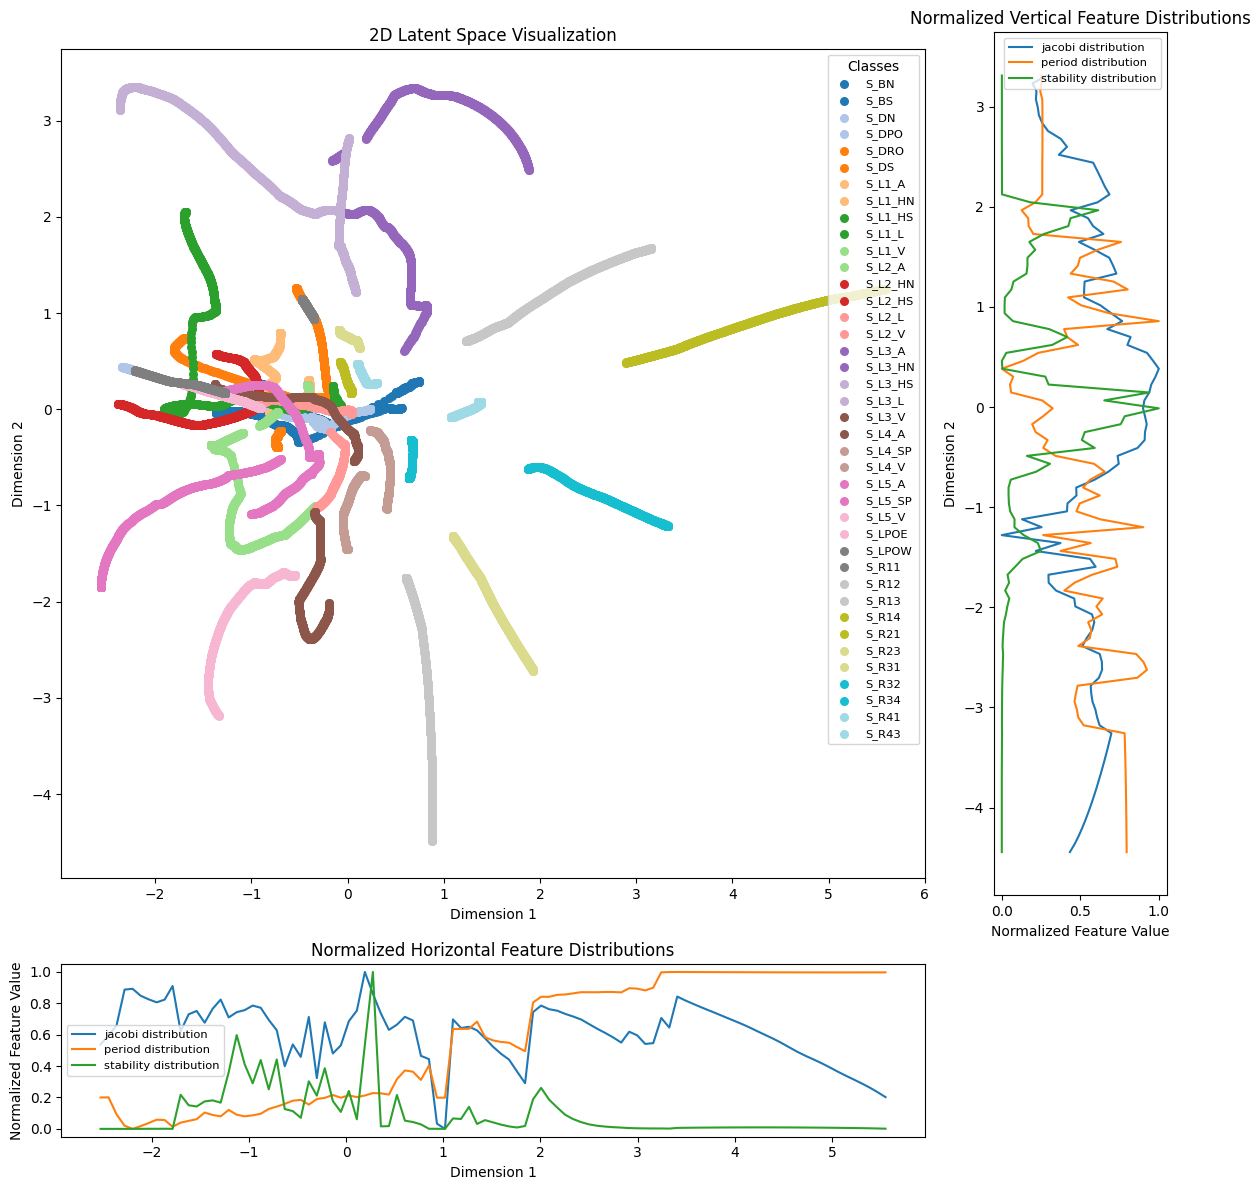

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_type


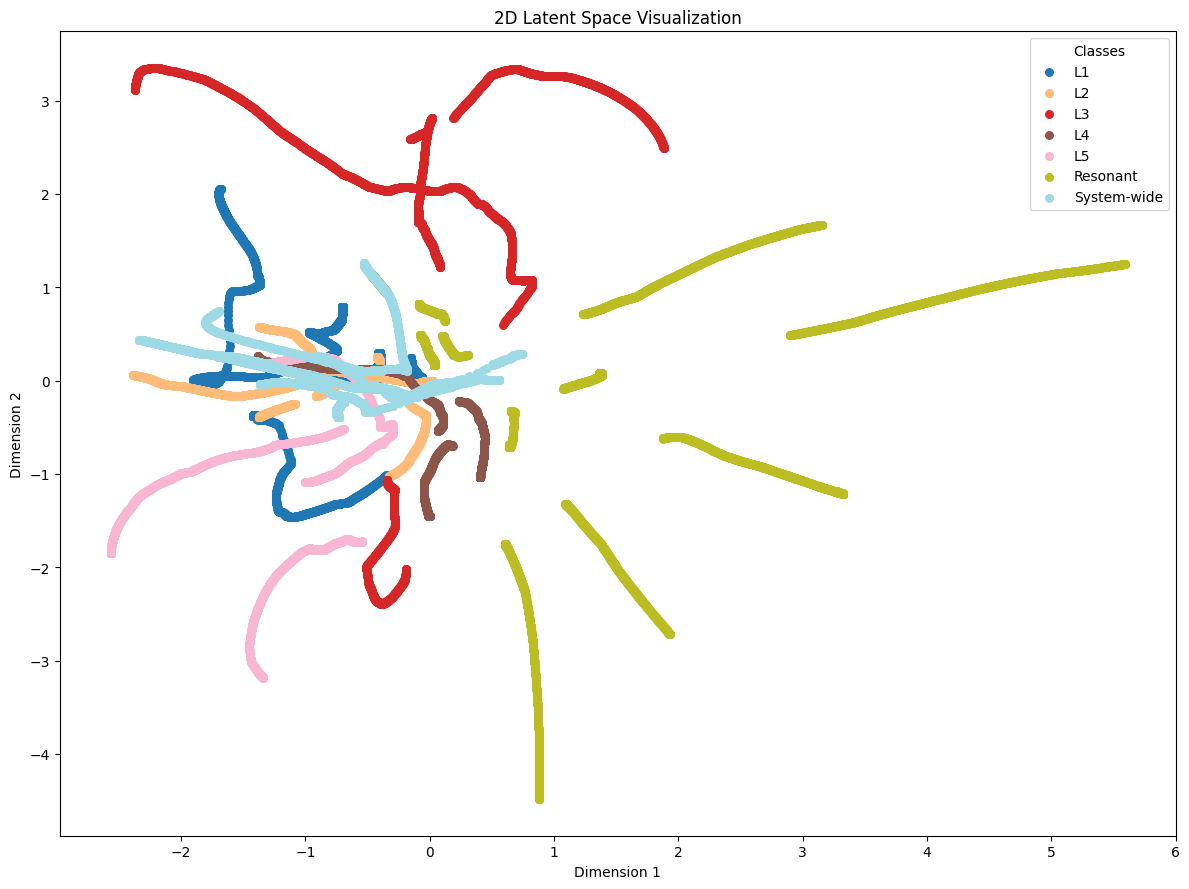

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_subtype


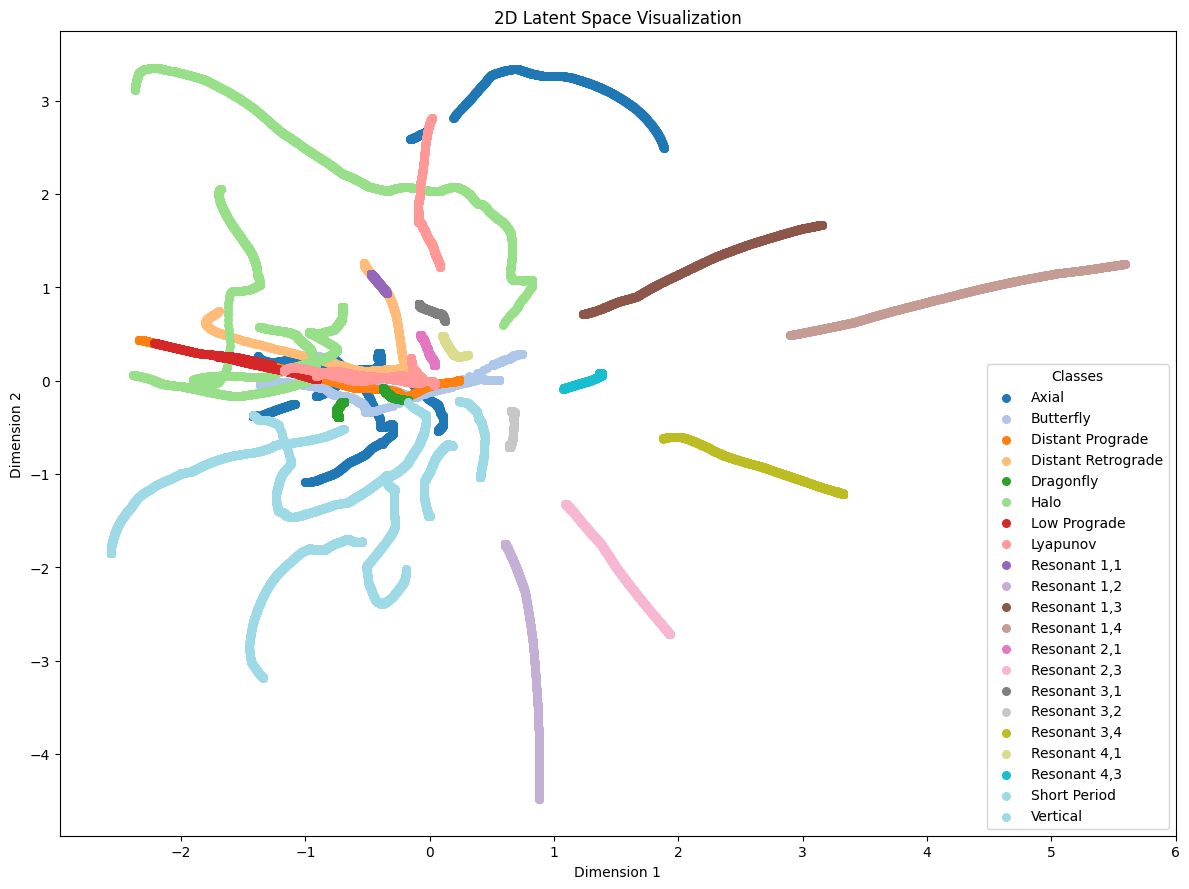

Saved plot to ../experiments/experiment_1/images/exp1_latent_space_direction


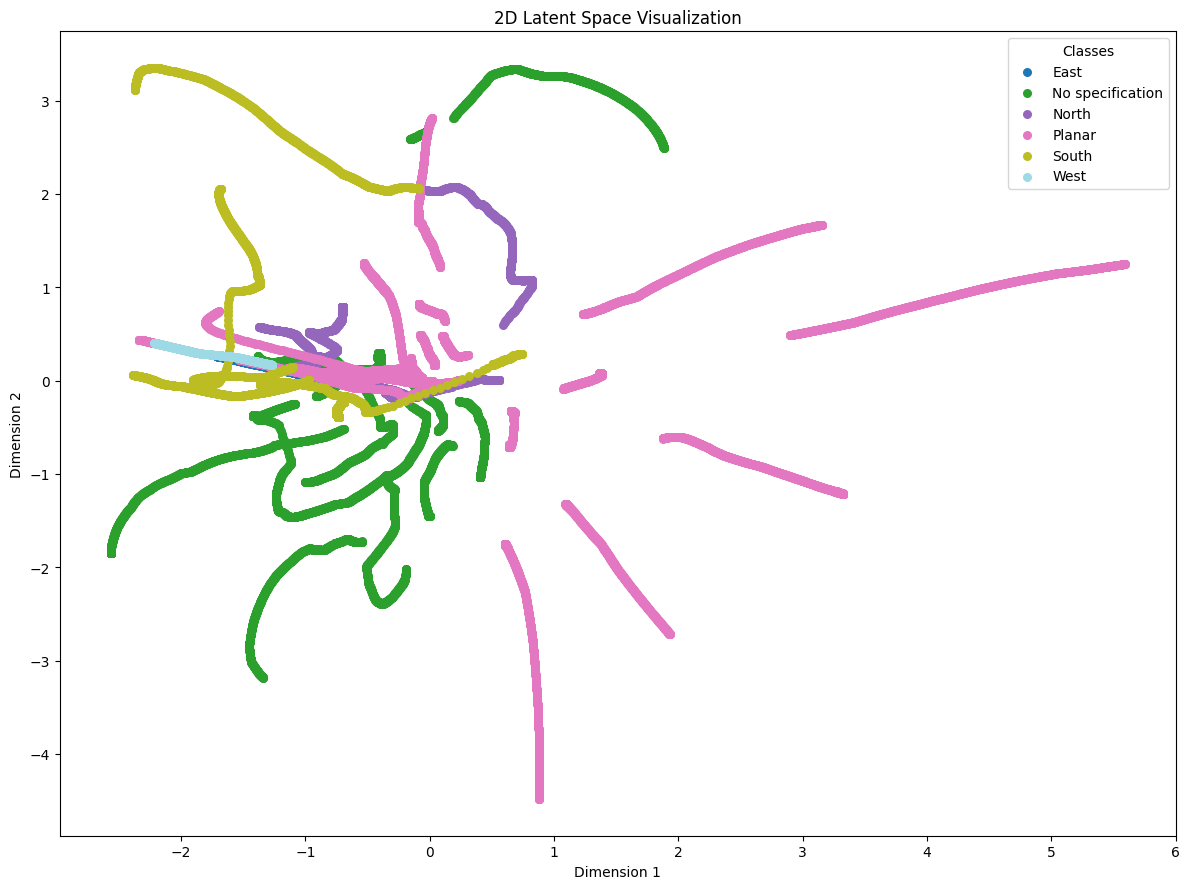

In [12]:
if want_to_generate_latent_space:
    if latent_representations.shape[1]==2:
        plot_latent_space_with_feature_distributions(latent_representations, np.array(classes[0]), save_path=latent_space_path +'_label',
                                                    many_classes=False, features=features, feature_names=feature_names, show_legend=True, legend_fontsize=8.25)
        plot_latent_space_2d(latent_representations, np.array(classes[1]), save_path=latent_space_path +'_type')
        plot_latent_space_2d(latent_representations, np.array(classes[2]), save_path=latent_space_path +'_subtype')
        plot_latent_space_2d(latent_representations, np.array(classes[3]), save_path=latent_space_path +'_direction')
    else:
        reduce_dimensions_plot_latent_space(latent_representations, np.array(classes[0]),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path +'_label',show_legend=False)
        reduce_dimensions_plot_latent_space(latent_representations, np.array(classes[1]),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path +'_type')  
        reduce_dimensions_plot_latent_space(latent_representations, np.array(classes[2]),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path +'_subtype')
        reduce_dimensions_plot_latent_space(latent_representations, np.array(classes[3]),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path +'_direction')


In [14]:
#| export
#| hide
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.cm as cm
from matplotlib import colormaps
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List, Dict, Any, Union
def plot_latent_space_2d_multi_labels(latent_representations: np.ndarray,  
                                      labels_list: List[np.ndarray],       
                                      titles: List[str],                   
                                      figsize: tuple = (12, 9),            
                                      save_path: Optional[str] = None,     
                                      many_classes: bool = False,          
                                      subplot_spacing: float = 0.5,        
                                      title_fontsize: int = 16,            # Parameter for title font size
                                      **kwargs: Any                        
                                     ) -> None:
    """
    Plots and optionally saves the latent space representations for multiple sets of labels.
    Each label set will create a subplot in a vertical grid layout.
    Titles are displayed with increased font size, legends are shown, but x and y axis labels are removed.
    """
    n_plots = len(labels_list)
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize)
    if n_plots == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot.

    for ax, labels, title in zip(axes, labels_list, titles):
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        class_names = label_encoder.classes_
        cmap = cm.get_cmap('tab20', len(class_names))
        markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']

        if many_classes:
            for class_idx, class_name in enumerate(class_names):
                class_mask = (encoded_labels == class_idx)
                color = cmap(class_idx)
                marker = markers[class_idx % len(markers)]
                ax.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                           label=class_name, marker=marker, color=color, s=30, **kwargs)
        else:
            unique_labels = np.unique(encoded_labels)
            for class_idx, class_name in zip(unique_labels, class_names):
                class_mask = (encoded_labels == class_idx)
                color = cmap(class_idx)
                ax.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                           label=class_name, color=color, s=30, **kwargs)

        ax.set_title(title, fontsize=title_fontsize)
        ax.legend(title="Classes", fontsize='small')  # Optionally adjust the fontsize for the legend
        ax.set_xlabel('')  # Remove x-axis label
        ax.set_ylabel('')  # Remove y-axis label

    plt.subplots_adjust(hspace=subplot_spacing)  # Adjust vertical spacing
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    plt.show()


/tmp/ipykernel_971756/1798861091.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(class_names))
/tmp/ipykernel_971756/1798861091.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(class_names))
/tmp/ipykernel_971756/1798861091.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(class_names))


Saved plot to ../experiments/experiment_1/images/exp1_latent_space_grid


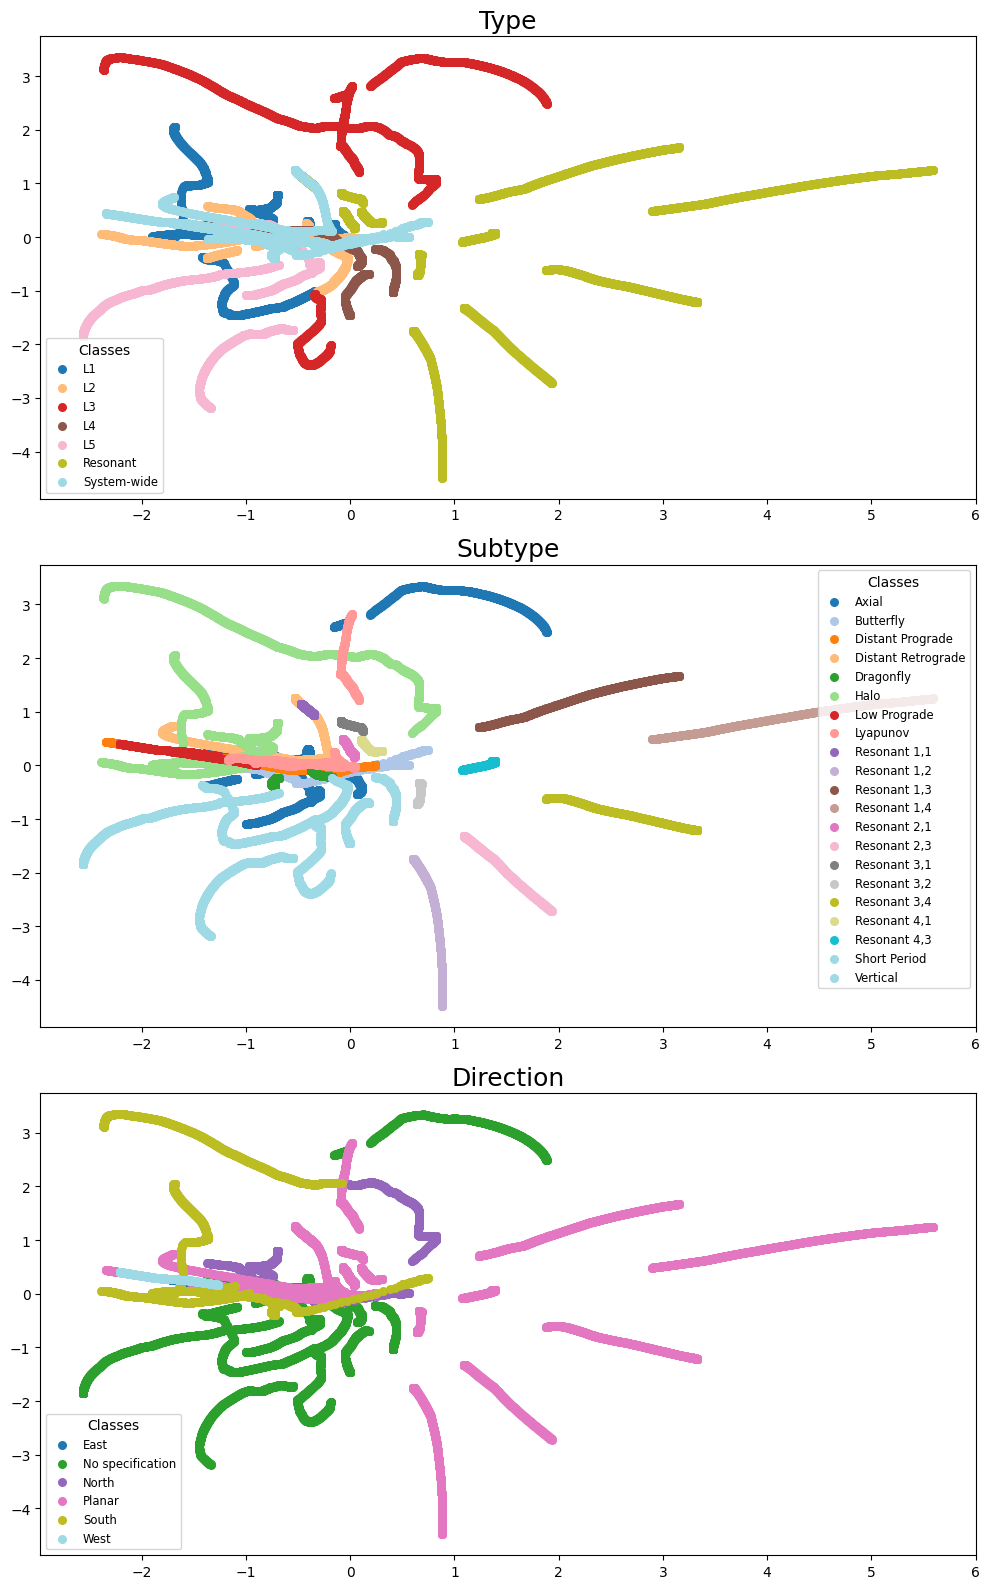

In [15]:
list_of_classes=[np.array(classes[1]),np.array(classes[2]),np.array(classes[3])]
plot_latent_space_2d_multi_labels(latent_representations, list_of_classes, titles=['Type', 'Subtype', 'Direction'], save_path=latent_space_path +'_grid', figsize=(10,16),
                     subplot_spacing=-0.1, title_fontsize=18)

In [ ]:
klk

## Clustering

In [ ]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_representations, classes, label_names=['label','type','subtype','direction'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

# Convergence

In [ ]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
df = pd.DataFrame(initial_conditions, columns=columns)
generated_data = np.load(generated_data_file)
generated_data.shape

(46, 100, 7)

In [ ]:
if generated_data.shape[2] == 7:
    inverted2_generation = generated_data[:,:,1:]
    inverted2_generation.shape
else:
    inverted2_generation = generated_data

display_generation = np.transpose(inverted2_generation, (0, 2, 1))
display_generation.shape

(46, 6, 100)

## Visualize

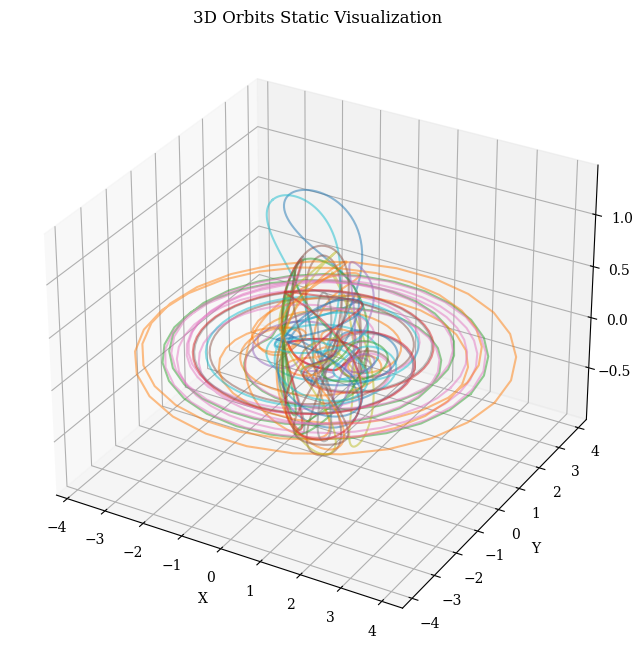

In [ ]:
visualize_static_orbits(display_generation, show_legend=False, save_path=converged_orbits_path)

In [ ]:
export_dynamic_orbits_html(display_generation, filename=dynamical_orbits_path)

Visualization saved to ../experiments/experiment_4/images/exp4_refined_orbits.html


## Metrics

In [ ]:
generated_scaled_data = scaler.transform(generated_data)
generation_latent_mean, generation_latent_deviation, generation_latent_epsilon = model.encoder(generated_scaled_data)
generation_latent_representations = latent_mean.numpy()
generation_combined_latent_representation = np.concatenate((generation_latent_mean, generation_latent_deviation), axis=1)

generation_combined_latent_representation.shape

(46, 4)

In [ ]:
if want_to_study_converged_orbits:
    non_matching_elements = find_non_matching_elements(combined_latent_representation, generation_combined_latent_representation)
    convergence_metrics = {'percentage_convergence':len(generated_data)/100 ,'percentage_novelty':len(non_matching_elements)/len(generated_data)*100 , 'average_iterations_convergence':df['iterations_convergence'].mean()}
    add_experiment_metrics(experiments_folder, params=params, metrics=convergence_metrics)

Metrics added to experiment with ID 4 in ../experiments/experiments.json.


## Latent Space

1415/1415 [==============================] - 7s 5ms/step


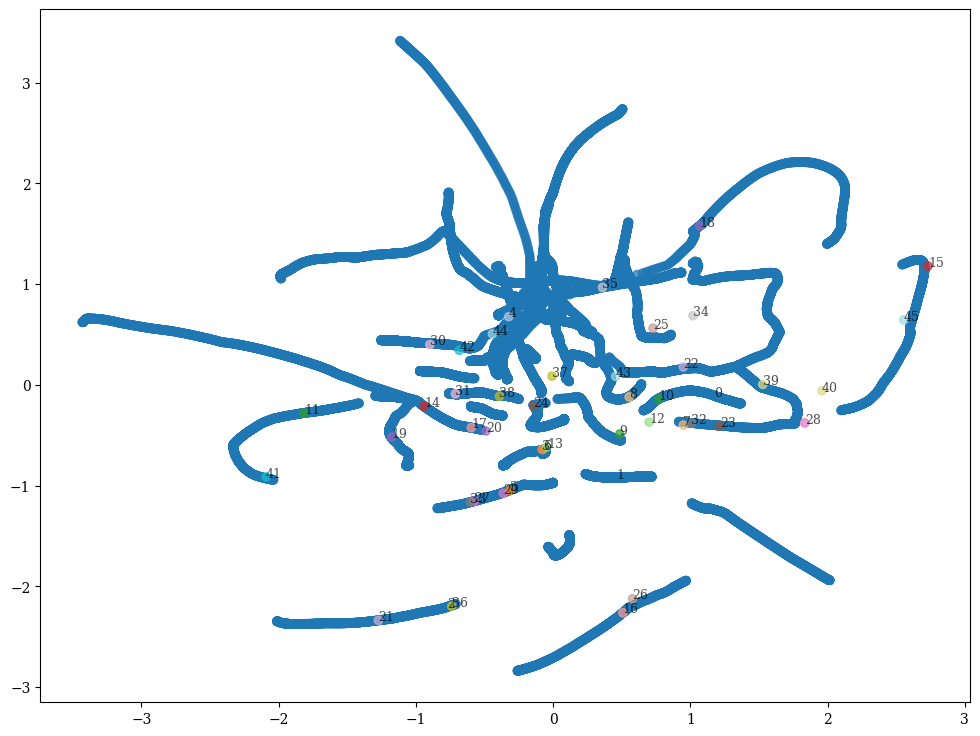

In [ ]:
if want_to_study_converged_orbits:
    if latent_representations.shape[1]==2:
        plot_combined_latent_space_2d(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder, 
            synthetic_labels=list(range(0, len(generated_scaled_data))),
            annotation_mode='numbers',
            save_path=combined_latent_space_path,
            show_legend=True
        )
    else:
        reduce_dimensions_plot_combined_latent_space(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder,
            techniques=['PCA','UMAP','t-SNE'],
            save_path=combined_latent_space_path
        )